## 필요한 모듈 임포트

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from datetime import datetime
import datetime as dt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import ElasticNet

from sklearn.metrics import mean_squared_error

In [3]:
# 운영체제에 따른 한글 지원을 설정한다. 지원되는 환경은 윈도우, 우분투, 구글 코랩 등이다.

import platform
plt.rc('figure', figsize=(10, 6))  # 그림 크기 설정
if platform.system() == 'Windows': # 윈도우
    from matplotlib import font_manager, rc
    font_path = "C:/Windows/Fonts/gulim.ttc"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)
elif platform.system() == 'Linux': # 우분투 또는 구글 코랩
    # !sudo apt-get install -y fonts-nanum*
    # !fc-cache -fv
    
    applyfont = "NanumBarunGothic"
    import matplotlib.font_manager as fm
    if not any(map(lambda ft: ft.name == applyfont, fm.fontManager.ttflist)):
        fm.fontManager.addfont("/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
    plt.rc("font", family=applyfont)
    plt.rc("axes", unicode_minus=False)

## 승촌보 수질 데이터 불러오기

보 이름

In [4]:
reservoir = 'Seungchonbo'

데이터 저장소

In [5]:
base_path = "https://github.com/codingalzi/water-data/raw/master/reservoirs/data/"

승촌보 데이터 불러오기. `'측정일/월'` 특성은 date time으로 파싱.

In [6]:
# ! pip install openpyxl

In [7]:
data_file = reservoir+".xlsx"
scb_yearly = pd.read_excel(base_path+data_file, 
                            skiprows=0, 
                            header=1, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=[0])  # 측정일/월 특성을 datetime으로 파싱

### 연도별 수질 데이터 통합

2012년도 데이터를 제외한 모든 데이터 통합 함수

In [8]:
# 반환값은 데이터프레임

def concat_yearly_df(df_yearly_dict):
    df_concat = pd.DataFrame()

    for year in list(df_yearly_dict.keys())[1:]:
        df_concat = pd.concat([df_concat, df_yearly_dict[year]])

    return df_concat

In [9]:
# 2013년도부터 통합
scb_yearly_df13 = concat_yearly_df(scb_yearly)

In [10]:
scb_yearly_df13 = scb_yearly_df13.set_index('측정일/월')

In [11]:
scb_yearly_df13.index.name = 'date/time'

In [12]:
scb_yearly_df13 = scb_yearly_df13.sort_index()

In [13]:
scb_yearly_df13

,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥
date/time,,,,,,,,,
2013-01-01 00:00:00,용봉,3.9,6.9,374.0,11.4,2.5,NaN,NaN,7.2
2013-01-01 01:00:00,용봉,3.9,6.9,375.0,11.4,2.5,NaN,NaN,6.9
2013-01-01 02:00:00,용봉,4.0,6.9,374.0,11.4,2.5,NaN,NaN,6.8
2013-01-01 03:00:00,용봉,4.1,6.9,375.0,11.4,2.5,NaN,NaN,6.9
2013-01-01 04:00:00,용봉,4.0,6.9,380.0,11.3,2.6,NaN,NaN,6.9
...,...,...,...,...,...,...,...,...,...
2022-05-23 19:00:00,용봉,26.6,6.9,419.0,NaN,6.7,5.825,0.108,66.2
2022-05-23 20:00:00,용봉,26.3,6.8,425.0,NaN,6.5,5.803,0.107,61.2
2022-05-23 21:00:00,용봉,25.9,6.8,417.0,NaN,6.7,5.909,0.107,58.3


## 승촌보 유량 데이터 추가

`시간` 특성은 date time으로 파싱해서 불러온다.

In [14]:
flow_data_file = reservoir+"_flow.xlsx"
scb_flow_yearly = pd.read_excel(base_path+flow_data_file, 
                            header=0, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=[0])  # 시간 특성을 date time으로 파싱

In [15]:
scb_flow_yearly['2013'].columns

Index(['시간', ' 상류수위(EL.m)', ' 하류수위(EL.m)', ' 유입량(㎥/s)', ' 방류량(㎥/s)'], dtype='object')

### 연도별 유량 데이터 통합

In [16]:
# 2013년부터 통합
scb_flow_yearly_df = concat_yearly_df(scb_flow_yearly)

In [17]:
scb_flow_yearly_df

,시간,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
0,2013-01-01 00:00:00,7.50,3.77,19.82,19.74
1,2013-01-01 00:10:00,7.50,3.77,19.78,19.76
2,2013-01-01 00:20:00,7.50,3.77,19.77,19.82
3,2013-01-01 00:30:00,7.50,3.77,19.77,19.73
4,2013-01-01 00:40:00,7.50,3.77,19.78,19.79
...,...,...,...,...,...
32947,2022-08-17 19:10:00,5.46,1.60,14.01,19.78
32948,2022-08-17 19:20:00,5.47,1.59,18.96,19.78
32949,2022-08-17 19:30:00,5.47,1.58,19.78,19.78
32950,2022-08-17 19:40:00,5.47,1.57,24.72,19.78


인덱스를 시간으로 지정

In [18]:
scb_flow_yearly_df = scb_flow_yearly_df.set_index('시간')

인덱스 이름 변경

In [19]:
scb_flow_yearly_df.index.name = 'date/time'

시간 기준으로 정렬

In [20]:
scb_flow_yearly_df = scb_flow_yearly_df.sort_index()

**10분 단위를 1시간 단위로 변경**  

시간별 평균값을 활용한다.

In [21]:
scb_flow_yearly_hour_df = scb_flow_yearly_df.resample("H").mean()

In [22]:
scb_flow_yearly_hour_df

,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
date/time,,,,
2013-01-01 00:00:00,7.500000,3.770000,19.773333,19.748333
2013-01-01 01:00:00,7.500000,3.770000,19.701667,19.706667
2013-01-01 02:00:00,7.500000,3.770000,19.748333,19.723333
2013-01-01 03:00:00,7.500000,3.770000,19.613333,19.610000
2013-01-01 04:00:00,7.500000,3.770000,19.661667,19.665000
...,...,...,...,...
2022-08-17 15:00:00,5.536667,1.618333,29.261667,25.190000
2022-08-17 16:00:00,5.525000,1.638333,23.243333,38.923333
2022-08-17 17:00:00,5.483333,1.626667,29.068333,44.878333


## 수질/유량 데이터 합병  

수질 데이터와 유량 데이터를 `date/time` 기준으로 합병한다.

In [23]:
# `pd.merge()`에서 `how = 'outer'` 키워드 인자 : 두 데이터에 사용된 모든 시간대의 데이터를 모두 추가한다(합집합).
scb_data = pd.merge(scb_yearly_df13, scb_flow_yearly_hour_df, left_index=True, right_index=True, how='outer')

In [24]:
scb_data

,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
date/time,,,,,,,,,,,,,
2013-01-01 00:00:00,용봉,3.9,6.9,374.0,11.4,2.5,NaN,NaN,7.2,7.500000,3.770000,19.773333,19.748333
2013-01-01 01:00:00,용봉,3.9,6.9,375.0,11.4,2.5,NaN,NaN,6.9,7.500000,3.770000,19.701667,19.706667
2013-01-01 02:00:00,용봉,4.0,6.9,374.0,11.4,2.5,NaN,NaN,6.8,7.500000,3.770000,19.748333,19.723333
2013-01-01 03:00:00,용봉,4.1,6.9,375.0,11.4,2.5,NaN,NaN,6.9,7.500000,3.770000,19.613333,19.610000
2013-01-01 04:00:00,용봉,4.0,6.9,380.0,11.3,2.6,NaN,NaN,6.9,7.500000,3.770000,19.661667,19.665000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-17 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.536667,1.618333,29.261667,25.190000
2022-08-17 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.525000,1.638333,23.243333,38.923333
2022-08-17 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.483333,1.626667,29.068333,44.878333


In [25]:

# 유량 데이터 2022년도 데이터를 더 많이 포함하기에 삭제 필요.
scb_data = scb_data[:len(scb_yearly_df13)]

# 유량 특성 이름에 공백이 사용되었기에 특성명에 공백 제거
scb_data.columns = [x.strip() for x in list(scb_data.columns)]

## 데이터셋 전처리

### 특성 선택

훈련에 사용하지 않을 특성 삭제

In [26]:
# scb_data.drop(['측정소명', '수소이온농도', '용존산소 mg/L'], axis=1, inplace=True)
scb_data = scb_data.drop(['측정소명', '수소이온농도', '용존산소 mg/L', '하류수위(EL.m)', '유입량(㎥/s)'], axis=1)

In [27]:
scb_data

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s)
date/time,,,,,,,,
2013-01-01 00:00:00,3.9,374.0,2.5,NaN,NaN,7.2,7.500000,19.748333
2013-01-01 01:00:00,3.9,375.0,2.5,NaN,NaN,6.9,7.500000,19.706667
2013-01-01 02:00:00,4.0,374.0,2.5,NaN,NaN,6.8,7.500000,19.723333
2013-01-01 03:00:00,4.1,375.0,2.5,NaN,NaN,6.9,7.500000,19.610000
2013-01-01 04:00:00,4.0,380.0,2.6,NaN,NaN,6.9,7.500000,19.665000
...,...,...,...,...,...,...,...,...
2022-05-21 04:00:00,21.6,471.0,5.9,7.710,0.095,47.5,5.580000,13.180000
2022-05-21 05:00:00,21.4,466.0,6.0,7.569,0.097,45.7,5.580000,13.165000
2022-05-21 06:00:00,21.3,465.0,6.1,7.495,0.099,48.8,5.580000,13.110000


### 클로로필 정규화

회귀 모델을 적용하기 전에 클로로필 값이 정규 분포인지 확인. 왼쪽으로 치우친 형태임.

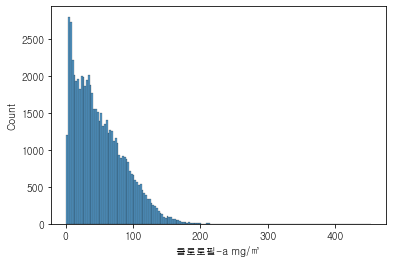

In [28]:
sns.histplot(scb_data['클로로필-a mg/㎥'])
plt.show()

`np.log1p()`를 사용해 로그변환하면 클로로필 값이 정규 분포에 가까워짐 

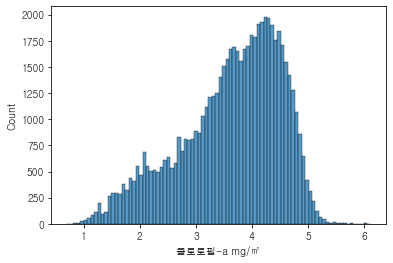

In [29]:
sns.histplot(np.log1p(scb_data['클로로필-a mg/㎥']))
plt.show()

클로로필 값을 로그 변환 뒤 `scb_data`에 추가

In [30]:
scb_data['log_Chl-a'] = np.log1p(scb_data['클로로필-a mg/㎥'])

In [31]:
scb_data.head(3)

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s),log_Chl-a
date/time,,,,,,,,,
2013-01-01 00:00:00,3.9,374.0,2.5,NaN,NaN,7.2,7.5,19.748333,2.104134
2013-01-01 01:00:00,3.9,375.0,2.5,NaN,NaN,6.9,7.5,19.706667,2.066863
2013-01-01 02:00:00,4.0,374.0,2.5,NaN,NaN,6.8,7.5,19.723333,2.054124


## 방류량 평균값 활용

**주의사항**

1일부터 14일 동안 방류량의 평균값의 중요도를 측정하고자 한다.
반면에 데이터는 계속해서 시간 단위 그대로 사용한다.

먼저 데이터셋을 복제해서 원본은 유지한다.

In [32]:
scb_df = scb_data.copy()

In [33]:
scb_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82257 entries, 2013-01-01 00:00:00 to 2022-05-21 08:00:00
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   수온 ℃         64513 non-null  float64
 1   전기전도도 μS/cm  64463 non-null  float64
 2   총유기탄소 mg/L   58617 non-null  float64
 3   총질소 mg/L     59921 non-null  float64
 4   총인 mg/L      58937 non-null  float64
 5   클로로필-a mg/㎥  62815 non-null  float64
 6   상류수위(EL.m)   82231 non-null  float64
 7   방류량(㎥/s)     82231 non-null  float64
 8   log_Chl-a    62815 non-null  float64
dtypes: float64(9)
memory usage: 6.3 MB


### 훈련 특성과 타깃  

- 훈련 특성: 측정소명과 클로로필을 제외한 특성 + 최대 14일 동안의 방류량/수온 평균값
- 타깃 특성: `log_Chl-a`

In [34]:
features_to_remove = ['클로로필-a mg/㎥', 'log_Chl-a']
basic_features = ['수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '상류수위(EL.m)', '방류량(㎥/s)']


아래 함수는 지정된 특성에 대해 윈도우 크기만큼의 기간동안의 평균값을 특성으로 추가한다.

- 일(24시간) 단위로 윈도우 사용
- 일(day) 수를 지정하면 24시간 단위로 변환해서 윈도우 적용.

In [35]:
from pandas import DataFrame
import re

def feature_windowing(df : DataFrame, feature : str, window: int) -> None:
    # df = df.set_index('시간')
    feature_ = re.split(' |\(', feature)[0] # 공백 또는 여는 괄호 기준 쪼개기 후 특성 이름만 사용. 단위 등은 삭제됨. 
    window_ = f"{window*24}H"

    new_features = dict()
    new_features[str(window) + 'D' +"_mean_" + feature_] = df[feature].rolling(window=window_, min_periods=1).mean() # 1개 이상의 값이 있는 경우 평균값 계산
    
    new_features = pd.DataFrame(new_features)

    return pd.concat([df, new_features], axis=1)

## 모델 훈련

### GradientBoosting

In [40]:
gb_reg = GradientBoostingRegressor(random_state=42)

하이퍼파라미터 조합 지정

In [41]:
param_grid = {
    "subsample":[0.6, 0.7],
    'max_depth':[10], 
    "learning_rate":[0.01, 0.05],
    'n_estimators':[900]
    }


그리드 탐색 실행 함수

- 모델, 하이퍼파라미터 조합, 특성, 윈도우 크기가 정해지면 해당 특성의 지정된 크기만큼의 
    윈도우 기간 동안의 평균값을 새로운 특성으로 추가함.
- 윈도우의 단위는 일(day)

In [42]:
def gridsearch(dataset, model, parameters, feature, windows, cv=3):

      # best models
    best_model_dict = dict()
    # test scores of the best models
    test_score_dict = dict()
    # train features of the best models
    input_features_dict = dict()
    # best hyperparameters for each window
    best_params_dict = dict()
    
    for window in windows:
        # window 특성 추가
        dataset_window = feature_windowing(dataset, feature, window)
        # 결측치 제거
        dataset_window.dropna(inplace=True)

        # 입력 및 타깃 특성 지정
        features_to_remove_ = features_to_remove + [feature]

        features_ = list(dataset_window.columns)
        for ft in features_to_remove_:
          features_.remove(ft)
        
        input_features = features_
        target_feature = 'log_Chl-a'

        # 입력 및 타깃 데이터셋 지정
        inputs = dataset_window.loc[:, input_features]
        targets = dataset_window[target_feature]

        # 훈련셋과 테스트셋 분리
        X_train, X_test, y_train, y_test = train_test_split(inputs, targets, random_state=42)

        added_feature = input_features[-1]
        print(f"==={added_feature} 모델 훈련===")
        # 그리드 탐색 훈련 시작
        model_grid = GridSearchCV(model, param_grid=parameters, cv=cv, verbose=5)
        model_grid.fit(X_train, y_train)

        estimator = model_grid.best_estimator_

        best_model_dict[added_feature] = estimator
        test_score_dict[added_feature] = estimator.score(X_test, y_test)
        input_features_dict[added_feature] = input_features
        best_params_dict[added_feature] = model_grid.best_params_

    return best_model_dict, test_score_dict, input_features_dict, best_params_dict


방류량을 기준으로 1일부터 14일까지의 윈도우를 개별적으로 적용하여 훈련한다.

In [43]:
window_feature = '방류량(㎥/s)'
windows = range(1, 15)
best_model_dict, test_score_dict, input_features_dict, best_params_dict = gridsearch(scb_df, gb_reg, param_grid, window_feature, windows, cv=3)

===1D_mean_방류량 모델 훈련===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END learning_rate=0.01, max_depth=10, n_estimators=900, subsample=0.6;, score=0.940 total time= 1.2min
[CV 2/3] END learning_rate=0.01, max_depth=10, n_estimators=900, subsample=0.6;, score=0.942 total time= 1.2min
[CV 3/3] END learning_rate=0.01, max_depth=10, n_estimators=900, subsample=0.6;, score=0.945 total time= 1.2min
[CV 1/3] END learning_rate=0.01, max_depth=10, n_estimators=900, subsample=0.7;, score=0.940 total time= 1.4min
[CV 2/3] END learning_rate=0.01, max_depth=10, n_estimators=900, subsample=0.7;, score=0.942 total time= 1.4min
[CV 3/3] END learning_rate=0.01, max_depth=10, n_estimators=900, subsample=0.7;, score=0.945 total time= 1.4min
[CV 1/3] END learning_rate=0.05, max_depth=10, n_estimators=900, subsample=0.6;, score=0.954 total time= 1.2min
[CV 2/3] END learning_rate=0.05, max_depth=10, n_estimators=900, subsample=0.6;, score=0.955 total time= 1.2min
[CV 3/3] END learnin

아래 함수는 훈련 후 각 특성의 중요도를 그래프로 그린다.

In [44]:
def feature_importance_barplot(best_model_dict, input_features_dict):
    models_trained = best_model_dict.keys()
    num_of_models = len(models_trained)

    fig, axs = plt.subplots(num_of_models, sharex=True, figsize=(10, num_of_models*4))

    for idx, model_ in enumerate(models_trained):
        ax = axs[idx]
        estimator_ = best_model_dict[model_]
        input_features_ = input_features_dict[model_]


        feature_series = pd.Series(data = estimator_.feature_importances_, index = input_features_)
        feature_series = feature_series.sort_values(ascending = False)

        colors = pd.Series('gray', index=feature_series.index)
        colors[input_features_[-1]] = 'red'
        
        sns.barplot(ax=ax, x = feature_series[:10], y = feature_series.index[:10], palette=colors)
        ax.set_title(model_)

    plt.subplots_adjust(hspace=0.4, wspace=0)
    plt.show()

윈도우 크기 1부터 14까지 훈련시킨 결과 각 특성의 중요도를 그래프로 그리면 다음과 같다.

- 윈도우 크기 7까지 방류량 중요도가 가장 높음.
- 윈도우 크기 4까지 방류량의 중요도가 계속 증가함.

<Figure size 1440x7200 with 0 Axes>

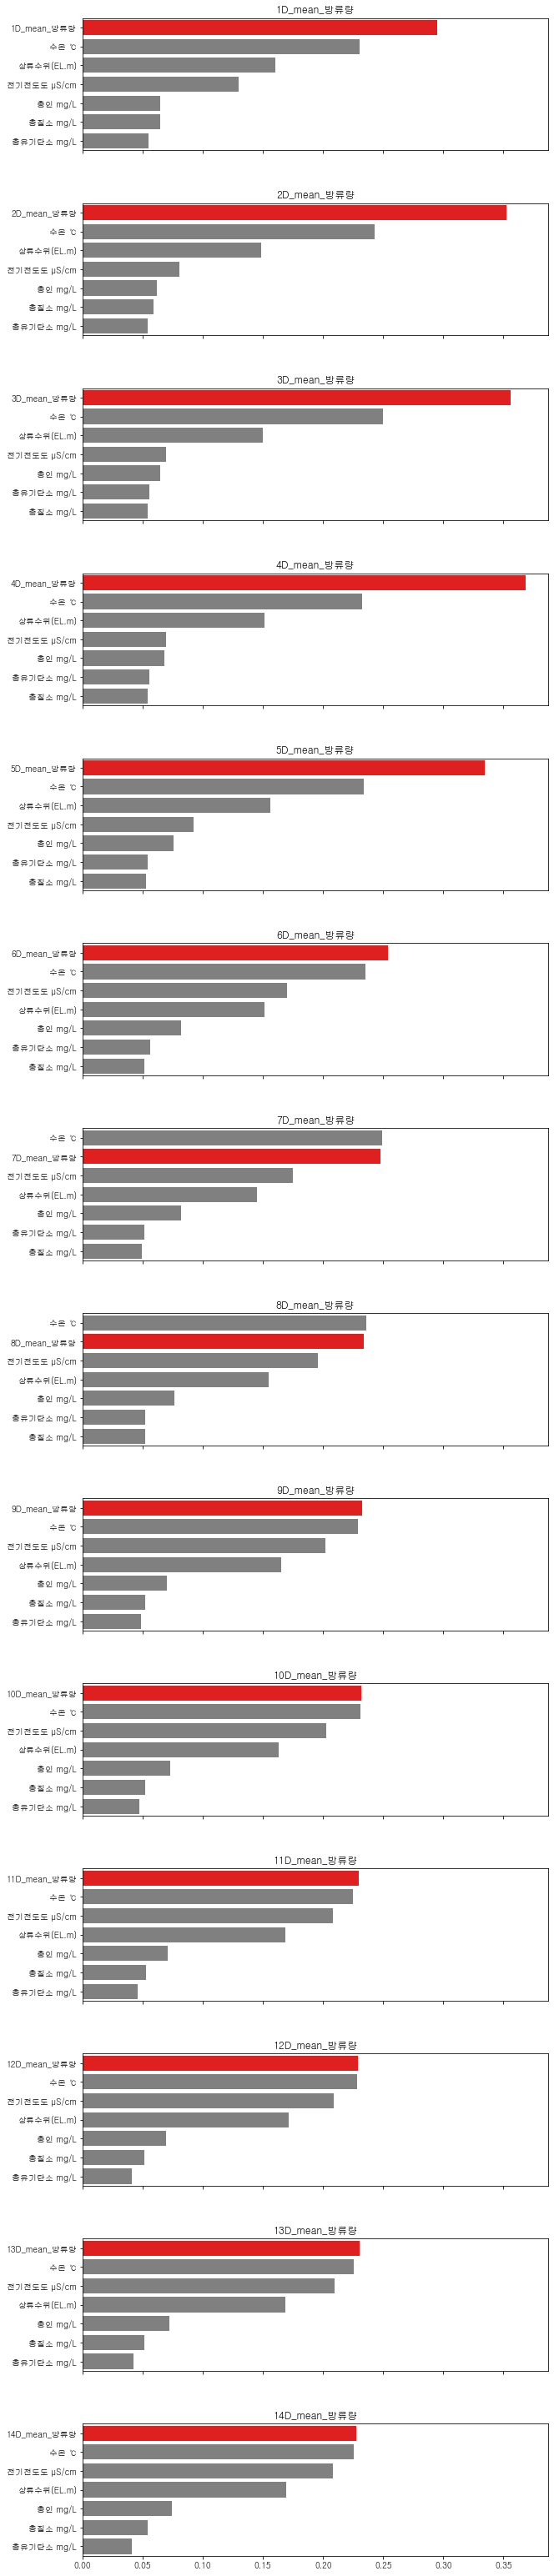

In [45]:
plt.figure(figsize=(20, 100))

feature_importance_barplot(best_model_dict, input_features_dict)

**평균 방류량 별 최선 모델의 특성 중요도**

모델 훈련에 사용된 특성을 통합하기 위해 `'?D방류량_mean'`을 `'평균방류량'`으로 통일시킨 후
최선 모델의 중요도로 구성된 사전을 구현한다.

In [46]:
# 평균 방류량 별 모델의 특성 중요도

models_trained = best_model_dict.keys()

# 최선 모델 별 특성 중요도로 구성된 사전
feature_importance_dict = dict()
    
for model_ in models_trained:
    estimator_ = best_model_dict[model_]
    input_features_ = input_features_dict[model_]

    feature_series = pd.Series(data = estimator_.feature_importances_, index = input_features_)
    # 특성 통일시키기
    features = ['수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '상류수위(EL.m)', '평균방류량']
    feature_series.index = features

    feature_importance_dict[model_] = feature_series    

특성의 순서를 재배치하여 데이터프레임으로 구성한다.
인덱스는 방류량 별 모델이 사용된다.

In [47]:
# 데이터프레임 지정. 인덱스는 모델명.
feature_importance_df = pd.DataFrame(feature_importance_dict).T

# 특성 순서 재배치
features_reorderd = ['평균방류량',  '상류수위(EL.m)', '수온 ℃', '전기전도도 μS/cm', '총인 mg/L', '총유기탄소 mg/L', '총질소 mg/L']
feature_importance_df = feature_importance_df[features_reorderd]
feature_importance_df

,평균방류량,상류수위(EL.m),수온 ℃,전기전도도 μS/cm,총인 mg/L,총유기탄소 mg/L,총질소 mg/L
1D_mean_방류량,0.294704,0.160410,0.230114,0.130068,0.064801,0.055104,0.064798
2D_mean_방류량,0.352274,0.148711,0.243209,0.080740,0.061966,0.054384,0.058716
3D_mean_방류량,0.356031,0.150217,0.250033,0.069211,0.064686,0.055352,0.054469
4D_mean_방류량,0.368736,0.151261,0.232780,0.069731,0.067892,0.055477,0.054123
5D_mean_방류량,0.334588,0.156049,0.233671,0.092534,0.075847,0.054305,0.053005
6D_mean_방류량,0.253987,0.151471,0.235480,0.169751,0.082196,0.056071,0.051044
7D_mean_방류량,0.247851,0.145109,0.249152,0.174998,0.082173,0.051637,0.049080
8D_mean_방류량,0.233670,0.154589,0.235687,0.195825,0.076440,0.051954,0.051835
9D_mean_방류량,0.232823,0.165402,0.229337,0.201613,0.070438,0.048457,0.051931
10D_mean_방류량,0.231531,0.162884,0.231305,0.202563,0.072717,0.047122,0.051876


**모델별 특성 중요도 막대그래프**

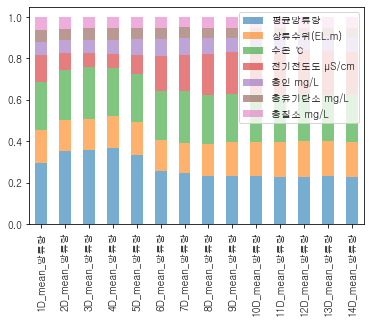

In [48]:
feature_importance_df.plot(kind='bar', stacked=True, alpha=0.6)
plt.legend(loc='upper right')
plt.show()

아래 그래프는 윈도우 크기에 따른 모델의 테스트 성능(score 기준)의 변화를 보여준다.
정확도의 성능이 최고 0.971328까지 올라간다.

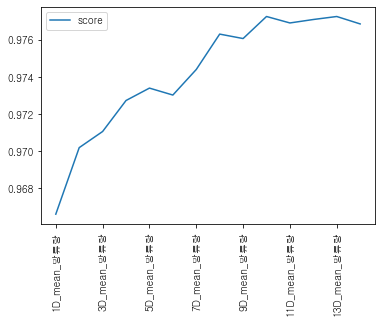

In [49]:
score_df = pd.DataFrame(test_score_dict, index=['score']).T
score_df.plot()
plt.xticks(rotation=90)
plt.show()

In [50]:
score_df

,score
1D_mean_방류량,0.966616
2D_mean_방류량,0.970193
3D_mean_방류량,0.971060
4D_mean_방류량,0.972727
5D_mean_방류량,0.973393
6D_mean_방류량,0.973020
7D_mean_방류량,0.974394
8D_mean_방류량,0.976297
9D_mean_방류량,0.976057
10D_mean_방류량,0.977243


**best_params_dict**

In [51]:
best_params_dict

{'1D_mean_방류량': {'learning_rate': 0.05,
  'max_depth': 10,
  'n_estimators': 900,
  'subsample': 0.6},
 '2D_mean_방류량': {'learning_rate': 0.05,
  'max_depth': 10,
  'n_estimators': 900,
  'subsample': 0.6},
 '3D_mean_방류량': {'learning_rate': 0.05,
  'max_depth': 10,
  'n_estimators': 900,
  'subsample': 0.6},
 '4D_mean_방류량': {'learning_rate': 0.05,
  'max_depth': 10,
  'n_estimators': 900,
  'subsample': 0.6},
 '5D_mean_방류량': {'learning_rate': 0.05,
  'max_depth': 10,
  'n_estimators': 900,
  'subsample': 0.6},
 '6D_mean_방류량': {'learning_rate': 0.05,
  'max_depth': 10,
  'n_estimators': 900,
  'subsample': 0.6},
 '7D_mean_방류량': {'learning_rate': 0.05,
  'max_depth': 10,
  'n_estimators': 900,
  'subsample': 0.7},
 '8D_mean_방류량': {'learning_rate': 0.05,
  'max_depth': 10,
  'n_estimators': 900,
  'subsample': 0.6},
 '9D_mean_방류량': {'learning_rate': 0.05,
  'max_depth': 10,
  'n_estimators': 900,
  'subsample': 0.7},
 '10D_mean_방류량': {'learning_rate': 0.05,
  'max_depth': 10,
  'n_estimato